In [1]:
%load_ext autoreload
%autoreload 2

In [12]:
import sys
import os
project_root_path = "~/loutrebleu/menta/stroker"
sys.path.append(os.path.expanduser(project_root_path))

In [82]:
import numpy as np
import xsim
import xtools as xt
import pandas as pd
import torch
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA

from tqdm import tqdm
from collections import namedtuple

In [4]:
from stroker.tools.dataloader import new_dataloader
from stroker.model.vae import VAE

In [38]:
config_file = "/Users/yoshikawa/loutrebleu/menta/stroker/result/2025.02.12.013826/config.yaml"

In [48]:

cf = xt.Config(config_file)
cf.loader.batch_size = 1
cf.loader.shuffle = False
# data loader
cf.dataset.path = xt.join(project_root_path, cf.dataset.path)
# model
cf.validate.model_path = xt.join(project_root_path, cf.validate.model_path)
cf.validate.model_path = "/Users/yoshikawa/loutrebleu/menta/stroker/result/2025.02.12.013826/model_step=003000.pth"

In [49]:
loader = new_dataloader(cf)

In [50]:
vae_params = cf.model._cf
vae = VAE(**vae_params)

In [52]:
  # load weight
state_dict = torch.load(cf.validate.model_path, weights_only=True)
vae.load_state_dict(state_dict)

<All keys matched successfully>

In [71]:
Data = namedtuple("Data", "image latent recons")

In [72]:
db = []
for image, _ in tqdm(loader):
    data = vae(image)

    data = Data(
        image.detach().numpy().squeeze(),
        data.latent.detach().numpy().squeeze(),
        data.recons.detach().numpy().squeeze(),
    )
    db.append(data)

  0%|          | 0/52 [00:00<?, ?it/s]

100%|██████████| 52/52 [00:00<00:00, 205.77it/s]


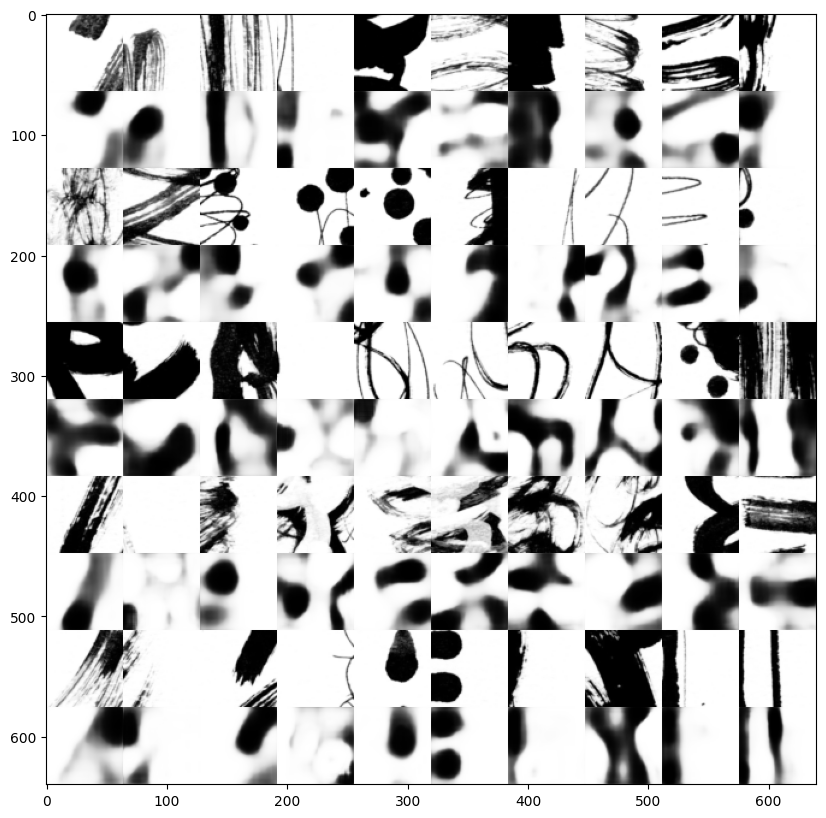

In [78]:
images_to_show = []
for row in range(5):
    image_to_show_row = []
    for column in range(10):
        data = db[10 * row + column]
        image_to_show = np.vstack([data.image, data.recons])
        image_to_show_row.append(image_to_show)
    image_to_show_row = np.hstack(image_to_show_row)
    images_to_show.append(image_to_show_row)

fig, ax = plt.subplots(figsize=(10, 10))
images_to_show = np.vstack(images_to_show)    
plt.imshow(images_to_show, cmap="Greys_r")
plt.show()


# Latent Analysis

In [ ]:
latents = np.vstack([
    data.latent
    for data in db
])

array([[-0.23761052, -0.0636555 ,  0.81470793, ...,  0.96017027,
         0.05771065,  0.84577996],
       [ 1.0612657 ,  0.7998655 ,  0.45315394, ...,  0.18352665,
         1.3479165 ,  0.41060883],
       [ 0.52982396, -0.16008532,  0.6624807 , ...,  0.50676   ,
        -0.14670089,  0.4455759 ],
       ...,
       [ 0.21791881,  0.6015018 ,  1.3358442 , ..., -0.54646933,
         1.4909408 ,  0.15748878],
       [-0.41105077,  0.20906152,  1.2676363 , ...,  0.24334902,
         0.4534975 , -0.02603044],
       [ 0.61009264,  0.63292676, -0.03290218, ...,  0.9659371 ,
         0.36483666,  1.1306028 ]], shape=(52, 256), dtype=float32)

In [83]:
pca = PCA()
pca.fit(latents)
feature = pca.transform(latents)

In [103]:
clist = np.zeros(len(latents))
# vertival
clist[2] = 2
clist[3] = 3
clist[49] = 4
# round
clist[14] = 7
clist[13] = 6

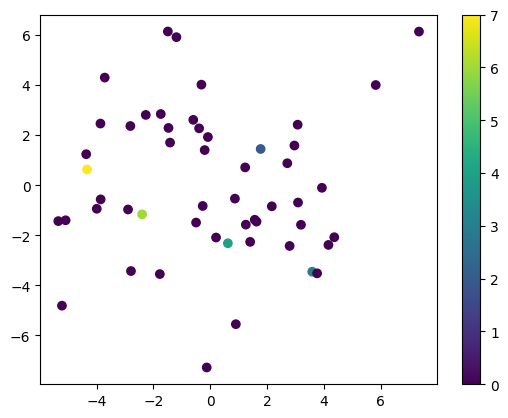

In [104]:
plt.scatter(
    feature[:, 0],
    feature[:, 1],
    c=clist,
)
plt.colorbar()

# NEW IMAGE Generation

In [79]:
idx1 = 3
idx2 = 14

data1 = db[idx1]
data2 = db[idx2]

new_latent = 0.5 * (data1.latent + data2.latent)

array([-0.37702656,  0.46068737, -0.21099515,  0.6475276 ,  0.3185036 ,
        0.03657374,  0.8486352 ,  0.42406687,  0.3245479 ,  0.5420352 ,
        0.9600506 ,  0.2758823 ,  0.06519511, -0.13719183,  0.75728416,
        0.48099294, -0.06017993,  0.4047876 ,  0.5497342 ,  0.8753968 ,
        1.1715527 ,  0.3195635 ,  0.3766654 ,  0.52858317,  0.29099596,
       -0.03549862,  0.44412348,  0.75531566,  0.82279015,  0.6138243 ,
        0.80839837, -0.18286052,  0.27784956,  0.5421408 ,  0.70695424,
        0.36516944, -0.07392055,  0.64664507,  0.8713034 ,  0.6079625 ,
        0.11626998,  0.04074627,  0.42214918,  1.050318  ,  0.19920094,
        0.49752876,  0.23899117, -0.22900382,  0.05654579,  0.5608468 ,
       -0.06145338,  0.60165364,  0.0122848 , -0.47637725, -0.12974909,
        0.1164811 ,  0.47173887,  0.21938255,  0.57809424,  0.8288243 ,
        0.32592654,  0.09622055,  0.9643845 ,  0.8243114 ,  0.02325988,
       -0.29181552,  0.26176882,  0.22066677,  0.8042615 , -0.37

In [106]:
new_feature = pca.transform([new_latent])

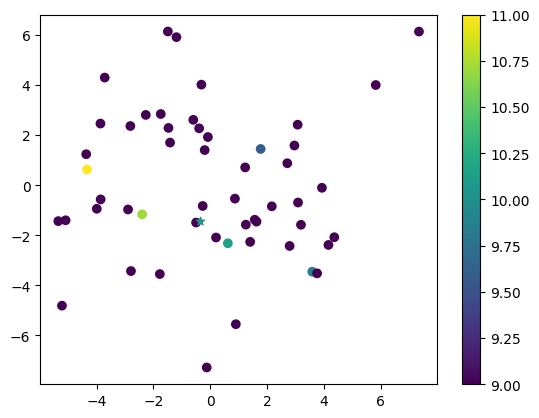

In [109]:
plt.scatter(
    feature[:, 0],
    feature[:, 1],
    c=clist,
)
plt.scatter(
    new_feature[0, 0],
    new_feature[0, 1],
    marker='*',
    c=10
)
plt.colorbar()

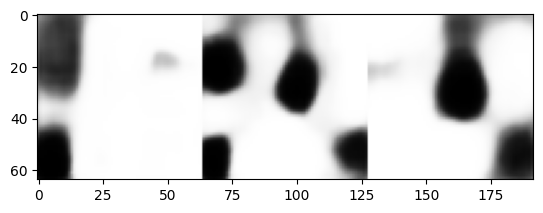

In [115]:
t_new_latent = torch.from_numpy(new_latent).float().unsqueeze(0)
new_recons = vae.decode(t_new_latent).squeeze()
new_images = np.hstack([
    data1.recons, new_recons, data2.recons
])
plt.imshow(new_images, cmap="Greys_r")

## new 2

In [124]:
idx3 = 49
idx4 = 14

data3 = db[idx3]
data4 = db[idx4]

new_latent_2 = 0.5 * (data3.latent + data4.latent)

In [125]:
new_feature_2 = pca.transform([new_latent_2])

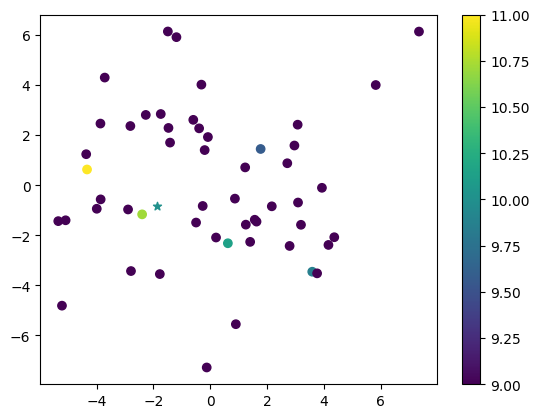

In [127]:
plt.scatter(
    feature[:, 0],
    feature[:, 1],
    c=clist,
)
plt.scatter(
    new_feature_2[0, 0],
    new_feature_2[0, 1],
    marker='*',
    c=10
)
plt.colorbar()

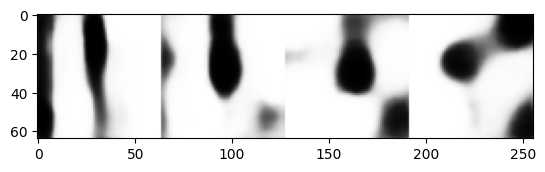

In [129]:
t_new_latent_2 = torch.from_numpy(new_latent_2).float().unsqueeze(0)
new_recons_2 = vae.decode(t_new_latent_2).squeeze()
new_images_2 = np.hstack([
    data3.recons, new_recons_2, data4.recons, db[13].recons
])
plt.imshow(new_images_2, cmap="Greys_r")